<a href="https://colab.research.google.com/github/atamanch/AI-ML/blob/master/TensorFlow/MNIST%20Project/MNIST_Dataset_Hacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Beginner MNIST Neural Net Project

Goal: To train a Deep Neural Network on the MNIST handwritten image dataset with above 98% accuracy.



## Load a recent version of TensorFlow

In [0]:
# Install TensorFlow using Colab's tensorflow_version command
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

## Import Libraries

Import TensorFlow, Numpy, Matplotlib libraries.

Also import the TensorFlow datasets library so we can use the MNIST dataset.


In [55]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Print version of TensorFlow currently imported
print(tf.__version__)

2.2.0


Problem: Human handwriting is imperfect compared to computerized text. Train a model to correctly predict the English characters within a set of handwritten images.

## Load MNIST
Load with the following arguments:


*   shuffle_files: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
*   as_supervised: Returns tuple (img, label) instead of dict {'image': img, 'label': label}

In [0]:
# Load the mnist dataset using tdfs
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    try_gcs=True
)

# Output one example to verify dataset has been imported
print(ds_train)

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


## Next up we build the training pipeline.

We apply the following transormations to the dataset.


*   ds.map: TFDS provides the images as tf.uint8 encoding, while the model expects tf.float32, so normalize the images to float32.
*   ds.cache As the dataset fits into memory, cache it before shuffling for better performance. Note: Random transformations should be applied after caching.
*   ds.shuffle: For true randomness, set the shuffle buffer to the full size of the dataset.
Note: For bigger datasets which do not fit in memory, a standard value is 1000 if your system allows it.
*   ds.batch: Batch after shuffling to get unique batches at each epoch.
*   ds.prefetch: It is good practice to end the pipeline by prefetching for performance.



In [0]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

## Build evaluation pipeline
The Testing pipeline is similar to the training pipeline, with small tweaks:


*   There is no ds.shuffle() call
*   Caching is done after batching (as batches can be the same between epoch)


In [0]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# Define the plotting curves
This will be used to graph model accuracy and loss over time

In [0]:
"""
def plot_curve(epochs, hist, list_of_metrics):
  # Plot a curve of one or more classification metrics vs. epoch.
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure.Figure()
  plt.pyplot.xlabel("Epoch")
  plt.pyplot.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.pyplot.plot(epochs[1:], x[1:], label=m)

  plt.pyplot.legend()

print("Loaded the plot_curve function.")
"""

def plot_acc(hist):
  # plot the accuracy
  plt.title('Accuracy History')
  plt.plot(hist.history['accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.show()
  
def plot_loss(hist):
  # plot the loss
  plt.title('Loss History')
  plt.plot(hist.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

## Build and train the model

Input the training pipeline built above into Keras and define model parameters

In [0]:
def create_model(learning_rate):

  # Use an input shape of 28x28 because the images in MNIST are 28x28 pixels
  # reLU has been effective in most use cases including this one, add a relatively dense layer with 128 neurons
  # Use softmax activation function because we want a probability distribution

  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

  # Compile model with SCC loss function, Adam optimizer and Accuracy metric
  # SCC is used when you have two or more label classes
  # Adam optimizer uses Stochastic Gradient Descent and is efficient when dealing with large datasets
  # Accuracy metric is used to calculate how often predictions from the model are equal to the real labels

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  return model

def train_model(model, epochs, batch_size):


  # Fit the model using the training split, then validate using the test split
  history = model.fit(
      ds_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=ds_test
  )

  # To track the progress of training, take a snapshot of the model metrics at each epoch and add it to a dataframe.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist, history



# Invoke previously defined functions

In [75]:
# These variables are the hyperparameters for the model.
learning_rate = 0.0005
epochs = 10
batch_size = 4000

# Define model topography
my_model = create_model(learning_rate)

# Train the model
epochs, hist, history = train_model(my_model,epochs,batch_size)

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4739 - accuracy: 0.8741 - val_loss: 0.2528 - val_accuracy: 0.9297
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2228 - accuracy: 0.9378 - val_loss: 0.1903 - val_accuracy: 0.9452
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1720 - accuracy: 0.9510 - val_loss: 0.1566 - val_accuracy: 0.9564
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1399 - accuracy: 0.9608 - val_loss: 0.1346 - val_accuracy: 0.9629
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1176 - accuracy: 0.9668 - val_loss: 0.1205 - val_accuracy: 0.9649
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1003 - accuracy: 0.9717 - val_loss: 0.1086 - val_accuracy: 0.9675
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0872 - accuracy: 0.9760 - val_loss: 0.0997 - val_accuracy: 0.9702
Epoch 

# Plot output of accuracy and loss metrics

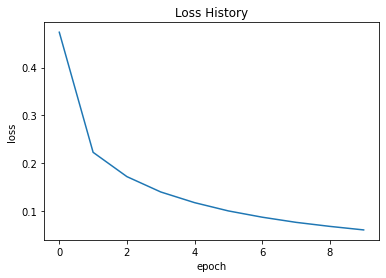

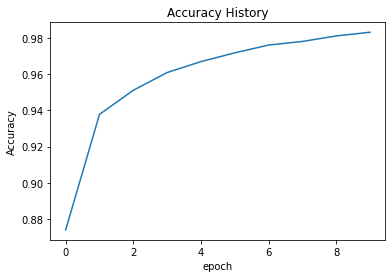

In [76]:
# Plot the collected metrics over time
"""
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)
"""
plot_loss(history)
plot_acc(history)
